Task 2: Signal in colored, Gaussian noise.
- Use the data file "challenge2.gwf", with channel name "H1:CHALLENGE2"
- The data contain a BBH signal with m1=m2=30 solar masses, spin = 0.
- What is the approximative time of the merger? (Hint: a plot of the q-transform could help)
- Generate a time-domain template waveform using approximate "SEOBNRv4_opt". with the same parameters as above. Plot this waveform.
- Calculate a PSD of the data, and plot this on a log-log scale. Use axes ranging from 20 Hz up to the Nyquist frequency.
- Use the template waveform and PSD to calculate the SNR time series. Plot the SNR time-series.

What is the matched filter SNR of the signal?


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
! pip install -q 'gwosc==0.5.4'
! pip install -q 'gwpy==2.0.2'
! pip install lalsuite
import gwosc
from gwosc.datasets import find_datasets
from gwosc import datasets
from gwosc.datasets import event_gps
from gwosc.datasets import run_segment
from gwosc.locate import get_event_urls
import gwpy
from gwpy.timeseries import TimeSeries

Reason for being yanked: Metadata is broken
     |████████████████████████████████| 1.4 MB 11.4 MB/s 
     |████████████████████████████████| 51 kB 4.3 MB/s 
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 3.6 MB 73.4 MB/s 
     |████████████████████████████████| 46.2 MB 53.1 MB/s 
     |████████████████████████████████| 1.4 MB 73.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 295 kB 77.2 MB/s 
  Created wheel for lscsoft-glue: filename=lscsoft_glue-3.0.1-cp37-cp37m-linux_x86_64.whl size=258428 sha256=6b567238c356be1b23eb543f55aa842b63c72c2ff17b8fd55f714e6395481191
  Stored in directory: /root/.cache/pip/wheels/62/ad/9a/6e89ceed9887a50c3c227beea125ad58f50b3622fbaf0873bf
Successfully built lscsoft-glue


In [5]:
! pip install PyCBC==1.18.0
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

     |████████████████████████████████| 6.3 MB 7.2 MB/s 
     |████████████████████████████████| 201 kB 52.8 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 


In [79]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc import frame

from pycbc.filter import matched_filter
import numpy

Now we've imported everything we need.

In [8]:
data = TimeSeries.read('/content/gdrive/My Drive/Google Colab/challenge2.gwf', 'H1:CHALLENGE2')

print(data)

TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: H1:CHALLENGE2)


In [9]:
print(data.duration)
print(data.sample_rate)

128.0 s
4096.0 Hz


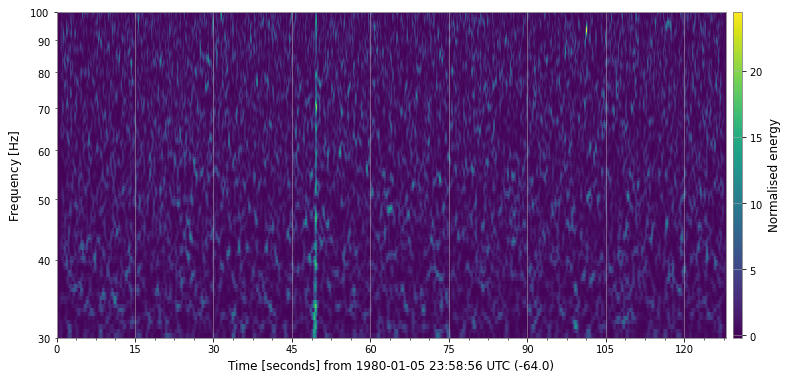

In [10]:
cq = data.q_transform(frange= (30,100), qrange=(80,110))
plot = cq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

The merge appears to be happening between 45 and 50 seconds

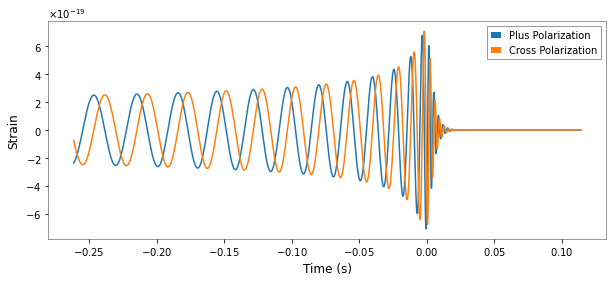

In [11]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         spin1x= 0,
                         spin1y= 0,
                         spin1z= 0,
                         spin2x= 0,
                         spin2y= 0,
                         spin2z= 0,
                         delta_t=1.0/4096,
                         f_lower=30)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

Let's zoom in on the point where they merge

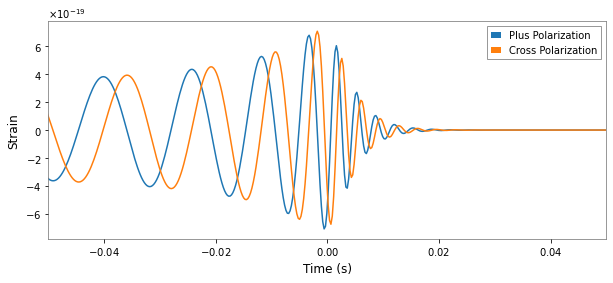

In [12]:
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.05, .05)
pylab.legend()
pylab.grid()
pylab.show()

Now that we've plotted the time-domain waveform, let's calculate a PSD of the data

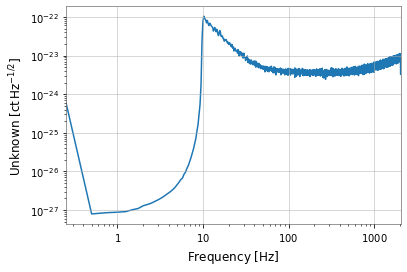

In [68]:
asd = data.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show(warn=False)

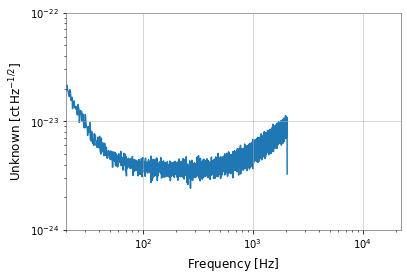

In [84]:
ax = plot.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(20, 22050)
ax.set_ylim(1e-24, 1e-22)
plot

We can also get this with pyCBC

No handles with labels found to put in legend.


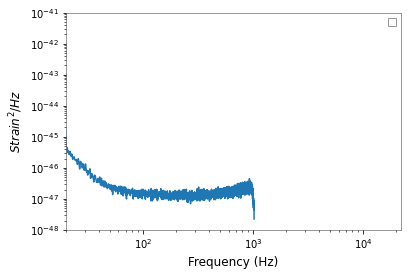

In [78]:
#Need to read the file again because apparently TimeSeries is different for gwpy and pyCBC
strain = frame.read_frame('/content/gdrive/My Drive/Google Colab/challenge2.gwf', 'H1:CHALLENGE2')

strain = highpass(strain, 20.0)
strain = resample_to_delta_t(strain, 1.0/2048)
conditioned = strain.crop(2,2)

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)



pylab.plot(psd.sample_frequencies, psd)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-48, 1e-41)
pylab.xlim(20, 22050)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

Now to find the SNR time series of this signal

In [82]:
#making signal model
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=30,
                     mass2=30,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

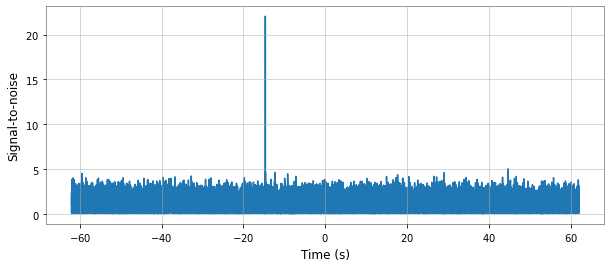

We found a signal at -14.6328125s with SNR 22.035991132520444


In [87]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)


pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

Success! We found a signal and the SNR